In [2]:
#!git clone https://github.com/anupamhap/mb.git
!git clone https://github.com/shreyasrivastava17/melbournewater.git

Cloning into 'melbournewater'...
remote: Counting objects: 201, done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 201 (delta 9), reused 0 (delta 0), pack-reused 184
Receiving objects: 100% (201/201), 22.11 MiB | 26.89 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [0]:
!pwd

/content


In [0]:
import os
os.chdir("melbournewater")


In [5]:
!ls

data  Debris Detection	heatmap added.ipynb  README.md


In [0]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging
import glob

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn

Using TensorFlow backend.


In [0]:
width = 58
height = 58

images = []

In [9]:
roots   = glob.glob('data/debris/*.PNG')
non_roots   = glob.glob('data/non-debris/*.PNG')
# non_roots   += glob.glob('data/non_tree/*.jpg')
print(len(roots), len(non_roots))
img=cv2.imread(roots[0])
print(img.shape)

46 55
(127, 257, 3)


In [0]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (5,5), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)


In [11]:
X_train_aug_roots = []
y_train_aug = []

def create_data(n=10):
   for i in range(len(roots)):
       img=cv2.imread(roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(1)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(1)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  368


In [12]:
def create_data(n=10):
   for i in range(len(non_roots)):
       img=cv2.imread(non_roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(0)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(0)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  808


In [13]:
print(len(roots))
print(X_train_aug_roots[0].shape)

46
(58, 58, 3)


In [14]:
for i in range(len(roots)):
     img=cv2.imread(roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(1)

for i in range(len(non_roots)):
     img=cv2.imread(non_roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
   
print(len(y_train_aug))

909


In [0]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.6))
#   seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [0]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence

images, labels = shuffle(X_train_aug_roots, y_train_aug)

In [0]:
for i in range(len(X_train_aug_roots)):
  if(X_train_aug_roots[i].shape[2]!=3):
    print(X_train_aug_roots[i].shape)

In [18]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype, images.shape)
print(type(images))
print(labels)

uint8 (909, 58, 58, 3)
<class 'numpy.ndarray'>
[1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1
 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1
 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0
 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0
 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1
 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1
 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0
 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0
 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          27712     
__________

In [20]:
keras_model.fit(images, labels, epochs=50, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 727 samples, validate on 182 samples
Epoch 1/50
727/727 [==============================] - 3s 4ms/step - loss: 0.7211 - acc: 0.4993 - val_loss: 0.6919 - val_acc: 0.5495
Epoch 2/50
727/727 [==============================] - 3s 3ms/step - loss: 0.6848 - acc: 0.5640 - val_loss: 0.6890 - val_acc: 0.5495
Epoch 3/50
727/727 [==============================] - 3s 4ms/step - loss: 0.6740 - acc: 0.6259 - val_loss: 0.6799 - val_acc: 0.5989
Epoch 4/50
727/727 [==============================] - 3s 3ms/step - loss: 0.6651 - acc: 0.6547 - val_loss: 0.6685 - val_acc: 0.6099
Epoch 5/50
727/727 [==============================] - 2s 3ms/step - loss: 0.6334 - acc: 0.7290 - val_loss: 0.6432 - val_acc: 0.6978
Epoch 6/50
727/727 [==============================] - 2s 3ms/step - loss: 0.5978 - acc: 0.7703 - val_loss: 0.5972 - val_acc: 0.7143
Epoch 7/50
727/727 [==============================] - 2s 3ms/step - loss: 0.5903 - acc: 0.7455 - val_loss: 0.6077 - val_acc: 0.6319
Epoch 8/50
128/727 [====>.....

727/727 [==============================] - 2s 3ms/step - loss: 0.5502 - acc: 0.7868 - val_loss: 0.5205 - val_acc: 0.7802
Epoch 9/50
727/727 [==============================] - 2s 3ms/step - loss: 0.5048 - acc: 0.7895 - val_loss: 0.4468 - val_acc: 0.8297
Epoch 10/50
727/727 [==============================] - 2s 3ms/step - loss: 0.4731 - acc: 0.8019 - val_loss: 0.4357 - val_acc: 0.8736
Epoch 11/50
727/727 [==============================] - 2s 3ms/step - loss: 0.4464 - acc: 0.8116 - val_loss: 0.4304 - val_acc: 0.8516
Epoch 12/50
727/727 [==============================] - 2s 3ms/step - loss: 0.3904 - acc: 0.8349 - val_loss: 0.3646 - val_acc: 0.8571
Epoch 13/50
727/727 [==============================] - 2s 3ms/step - loss: 0.3624 - acc: 0.8418 - val_loss: 0.4370 - val_acc: 0.8187
Epoch 14/50
727/727 [==============================] - 3s 3ms/step - loss: 0.4188 - acc: 0.8116 - val_loss: 0.3625 - val_acc: 0.8736
Epoch 15/50
608/727 [========================>.....] - ETA: 0s - loss: 0.3495 - ac

727/727 [==============================] - 3s 4ms/step - loss: 0.3609 - acc: 0.8514 - val_loss: 0.3302 - val_acc: 0.8846
Epoch 16/50
727/727 [==============================] - 3s 4ms/step - loss: 0.3165 - acc: 0.8652 - val_loss: 0.3220 - val_acc: 0.9121
Epoch 17/50
727/727 [==============================] - 3s 4ms/step - loss: 0.2781 - acc: 0.8968 - val_loss: 0.2840 - val_acc: 0.9066
Epoch 18/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2591 - acc: 0.9023 - val_loss: 0.2877 - val_acc: 0.9121
Epoch 19/50
727/727 [==============================] - 3s 4ms/step - loss: 0.2573 - acc: 0.8900 - val_loss: 0.2902 - val_acc: 0.8901
Epoch 20/50
727/727 [==============================] - 3s 4ms/step - loss: 0.2594 - acc: 0.9037 - val_loss: 0.2552 - val_acc: 0.9066
Epoch 21/50
727/727 [==============================] - 3s 3ms/step - loss: 0.2861 - acc: 0.8831 - val_loss: 0.2619 - val_acc: 0.9011
Epoch 22/50
608/727 [========================>.....] - ETA: 0s - loss: 0.2439 - a

727/727 [==============================] - 2s 3ms/step - loss: 0.2474 - acc: 0.9078 - val_loss: 0.2976 - val_acc: 0.9066
Epoch 23/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2491 - acc: 0.9051 - val_loss: 0.2343 - val_acc: 0.9121
Epoch 24/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2144 - acc: 0.9147 - val_loss: 0.2463 - val_acc: 0.9176
Epoch 25/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1818 - acc: 0.9409 - val_loss: 0.2308 - val_acc: 0.9176
Epoch 26/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1865 - acc: 0.9340 - val_loss: 0.2413 - val_acc: 0.9121
Epoch 27/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2027 - acc: 0.9230 - val_loss: 0.2643 - val_acc: 0.9121
Epoch 28/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1892 - acc: 0.9285 - val_loss: 0.2137 - val_acc: 0.9341
Epoch 29/50
608/727 [========================>.....] - ETA: 0s - loss: 0.1965 - a

727/727 [==============================] - 2s 3ms/step - loss: 0.1924 - acc: 0.9257 - val_loss: 0.2224 - val_acc: 0.9231
Epoch 30/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1686 - acc: 0.9381 - val_loss: 0.2195 - val_acc: 0.9396
Epoch 31/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1548 - acc: 0.9450 - val_loss: 0.2057 - val_acc: 0.9231
Epoch 32/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1616 - acc: 0.9367 - val_loss: 0.1981 - val_acc: 0.9286
Epoch 33/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1777 - acc: 0.9409 - val_loss: 0.1625 - val_acc: 0.9505
Epoch 34/50
727/727 [==============================] - 3s 4ms/step - loss: 0.2150 - acc: 0.9120 - val_loss: 0.2308 - val_acc: 0.9176
Epoch 35/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1686 - acc: 0.9422 - val_loss: 0.1891 - val_acc: 0.9396
Epoch 36/50
704/727 [============================>.] - ETA: 0s - loss: 0.1136 - a

727/727 [==============================] - 3s 4ms/step - loss: 0.1149 - acc: 0.9684 - val_loss: 0.1956 - val_acc: 0.9396
Epoch 37/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1468 - acc: 0.9491 - val_loss: 0.2095 - val_acc: 0.9341
Epoch 38/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1349 - acc: 0.9519 - val_loss: 0.2551 - val_acc: 0.9231
Epoch 39/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1478 - acc: 0.9491 - val_loss: 0.2471 - val_acc: 0.9231
Epoch 40/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1659 - acc: 0.9381 - val_loss: 0.1646 - val_acc: 0.9396
Epoch 41/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1240 - acc: 0.9642 - val_loss: 0.2416 - val_acc: 0.9341
Epoch 42/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1452 - acc: 0.9519 - val_loss: 0.2306 - val_acc: 0.9231
Epoch 43/50
704/727 [============================>.] - ETA: 0s - loss: 0.1072 - a

727/727 [==============================] - 3s 4ms/step - loss: 0.1051 - acc: 0.9656 - val_loss: 0.1813 - val_acc: 0.9341
Epoch 44/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1967 - acc: 0.9326 - val_loss: 0.2440 - val_acc: 0.9066
Epoch 45/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1384 - acc: 0.9422 - val_loss: 0.1957 - val_acc: 0.9396
Epoch 46/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1413 - acc: 0.9491 - val_loss: 0.2302 - val_acc: 0.9341
Epoch 47/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1238 - acc: 0.9601 - val_loss: 0.1800 - val_acc: 0.9505
Epoch 48/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1041 - acc: 0.9656 - val_loss: 0.2315 - val_acc: 0.9286
Epoch 49/50
727/727 [==============================] - 3s 4ms/step - loss: 0.0772 - acc: 0.9766 - val_loss: 0.2457 - val_acc: 0.9286
Epoch 50/50
727/727 [==============================] - 3s 4ms/step - loss: 0.1186

In [0]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [0]:
save_keras_model(keras_model, 'keras')

In [23]:
!ls

data		  heatmap added.ipynb  kerasmodel.json
Debris Detection  kerasmodel.h5        README.md


# New Section

In [0]:
from google.colab import files


files.download('kerasmodel.h5')
files.download('kerasmodel.json')


In [0]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [0]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
#     print(nxsteps)
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (58,58))
#             plt.imshow(subimg)
#             plt.show
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(subimg, 0))[0, 0])
#             print(test_prediction)
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [0]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

In [0]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 270
scale = 1.5
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('../test/*.PNG')
# print(test_images)
for fname in test_images:
#     print(fname)
    test_img=cv2.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

In [32]:
# os.chdir("content")
# !git pull origin melbournewater
!ls
# git pull origin experiment
# !git clone https://github.com/shreyasrivastava17/test.git

data		  heatmap added.ipynb  kerasmodel.json	test
Debris Detection  kerasmodel.h5        README.md


(289, 471, 3)


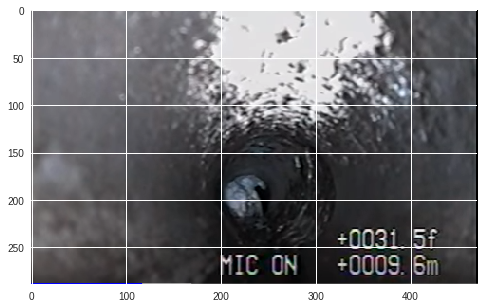

In [33]:
import matplotlib.pyplot as plt
img = cv2.imread("test/test1.PNG")
print(img.shape)
plt.imshow(img)
# cv2.imshow('image',img)

In [34]:
os.chdir("test")
!ls

heatmap added.ipynb  README.md	test1.PNG  test2.PNG  test3.PNG  test4.PNG


In [36]:
im = cv2.imread( "test1.PNG")
im = cv2.resize(im,(58,58))
print( round(inf_model.predict(np.expand_dims(im, 0))[0, 0]))

0.0


In [0]:
!git pull

Already up-to-date.


In [0]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

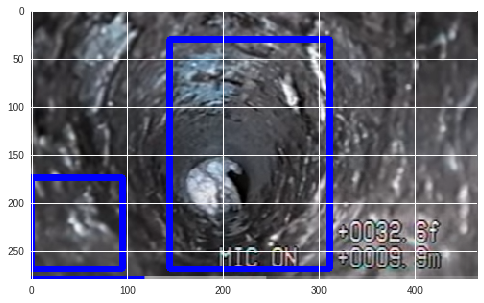

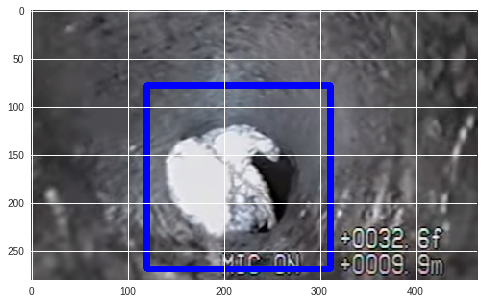

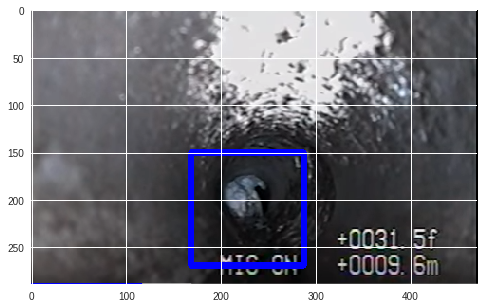

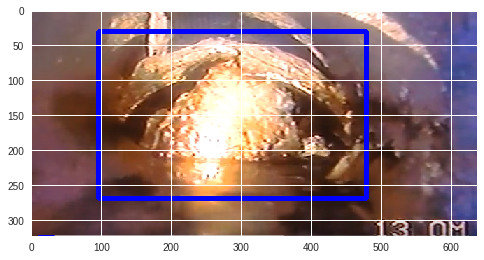

In [38]:
#print(scales,ystarts)
from collections import deque

heat_history=deque(maxlen=8)
def process_frame(image):
    boxes=[]
#     for i in range(len(scales)):
    boxes.append(find_roots(image, ystart, ystop, scale, pix_per_cell,cell_per_block )) #find_roots(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
#     heat_history.append(heatmap_img)
#     heatmap_img = np.array(heat_history).sum(axis=0)
    heatmap_img = apply_threshold(heatmap_img,1)#
    
    # # Find final boxes from heatmap using label function
    labels = label(heatmap_img)#
    draw_img = draw_labeled_bboxes(np.copy(image), labels)#
#     draw_img = draw_boxes(image,boxes)
#     print(boxes)
    return draw_img
test_images=glob.glob('*.PNG')
for fname in test_images:
#     print(fname)
    test_img=cv2.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    final_image=process_frame(test_img)
    plt.imshow(final_image)
    plt.show()
# plt.imshow(process_frame(im))


In [39]:
# os.chdir("Tree_Root_Detection")
# !wget 

--2018-07-16 07:56:28--  https://r2---sn-51uxj5-cvbe.googlevideo.com/videoplayback?ip=191.102.91.234


In [41]:
# !git pull
# # !ls
os.chdir("..")
!ls

data		  heatmap added.ipynb  kerasmodel.json	test
Debris Detection  kerasmodel.h5        README.md


In [43]:
!pip install moviepy

    100% |████████████████████████████████| 378kB 7.4MB/s 
    100% |████████████████████████████████| 3.3MB 7.3MB/s 
    100% |████████████████████████████████| 51kB 23.6MB/s 
  Running setup.py bdist_wheel for moviepy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ad/92/4d/a6c6307d4c2219d002646bd4a5987e31fd5697f6ea7778b2c0
Successfully built moviepy


In [44]:
from moviepy.editor import VideoFileClip

output_location = 'sewer_footage1_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("data/test_images/sewer_debris.mp4").subclip(10,30)

video_output = video_input.fl_image(process_frame) #NOTE: this function expects color images!!

#%time undist_clip.write_videofile(undist_output, audio=False)
# print("anupam")
video_output.write_videofile(output_location, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()
video_output.reader.close()
video_output.audio.reader.close_proc()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)901120/45929032 bytes (2.0%)2654208/45929032 bytes (5.8%)5881856/45929032 bytes (12.8%)9863168/45929032 bytes (21.5%)13664256/45929032 bytes (29.8%)17670144/45929032 bytes (38.5%)21471232/45929032 bytes (46.7%)25411584/45929032 bytes (55.3%)29442048/45929032 bytes (64.1%)33357824/45929032 bytes (72.6%)37380096/45929032 bytes (81.4%)41345024/45929032 bytes (90.0%)45318

100%|██████████| 600/600 [01:22<00:00,  7.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sewer_footage1_output.mp4 



In [48]:
!ls

data		     kerasmodel.h5    sewer_footage1_output.mp4
Debris Detection     kerasmodel.json  test
heatmap added.ipynb  README.md


In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')


In [0]:
os.chdir('..')

In [51]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))



In [0]:
!git commit -m "output video"

In [0]:
!git config --global user.email "anupamb266@gmail.com"
! git config --global user.name "anupamhap"

In [0]:
!git push

In [0]:
!ls

Crack_Detection		   sewer_footage1	      test_image1.png
first working model.ipynb  sewer_footage1_output.mp4  Tree_Root_Detection


In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')

In [0]:
!git pull

fatal: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [0]:
!git reset

Saved working directory and index state WIP on master: 905807b output video
